# Facial Emotion Recognition (Best Model And Testing)

### Library Imports

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from tensorflow.keras import regularizers as reg
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras import regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, SpatialDropout2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Reading and Splitting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [7]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# defining dir variables 
root_dir = '/content/drive/MyDrive/Data/'
train_dir = root_dir + 'train/'
valid_dir = root_dir + 'valid/'
test_dir = root_dir + 'test/'

In [8]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= train_dir, 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )


train_data.class_indices

Found 22992 images belonging to 7 classes.


{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [9]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= valid_dir, 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 5767 images belonging to 7 classes.


# Data Visualization

In [ ]:
class_names = train_data.class_names
num_classes = len(class_names)
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


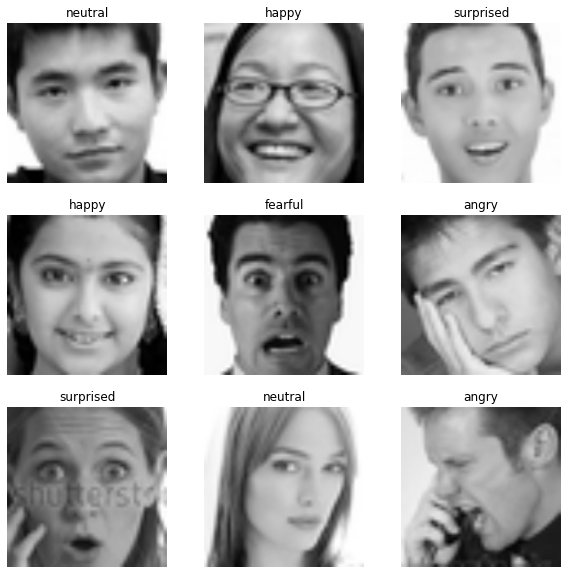

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
target_var = os.listdir(test_dir)
target_var

['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

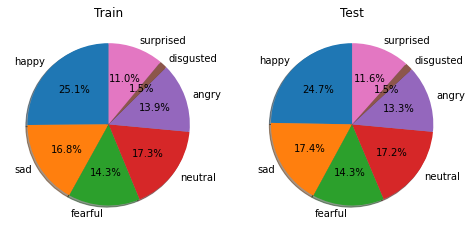

Emotion : happy
	Training : 5772
	 Testing : 1774
	 Validation : 1445
Emotion : sad
	Training : 3864
	 Testing : 1247
	 Validation : 967
Emotion : fearful
	Training : 3279
	 Testing : 1024
	 Validation : 819
Emotion : neutral
	Training : 3972
	 Testing : 1233
	 Validation : 995
Emotion : angry
	Training : 3196
	 Testing : 958
	 Validation : 800
Emotion : disgusted
	Training : 349
	 Testing : 111
	 Validation : 88
Emotion : surprised
	Training : 2537
	 Testing : 831
	 Validation : 635


In [ ]:
x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in target_var ])
#x_valid = np.array([ len(os.listdir(valid_dir+i+'/')) for i in target_var ])
x_test = np.array([ len(os.listdir(test_dir+i+'/')) for i in target_var ])

label = target_var
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
#axes[2].pie(x_valid, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
#axes[2].set_title('Validation')
plt.show()

for i in target_var:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(train_dir+i+'/'))) +'\n\t Testing : ' + str(len(os.listdir(test_dir+i+'/')))+'\n\t Validation : ' + str(len(os.listdir(valid_dir+i+'/'))))

# Data Augmentation

- Resize the images (48x48)
- Scaling/Normalization (1 to 255)
- Randomly flip images (Horizontally)
- Randomly rotate images (up to 20°)

In [ ]:
data_augmentation = Sequential([
    Resizing(48, 48), # let 180
    Rescaling(1./255),
    #RandomFlip("horizontal"),
    #RandomRotation(0.2)
])

# Model Metrics

In [ ]:
def plot_model_performance(hist, model_name=None, save=False):
    model_hist = pd.DataFrame(hist.history)
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=model_hist[['accuracy', 'val_accuracy']])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    
    if save and model_name:
        plt.title(f'{model_name} Accuracy Graph')
        plt.savefig(f'Images/{model_name} accuracy graph.png', transparent=True, bbox_inches='tight')

# Model Training

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

#  Models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report , roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
sgd_opt = SGD(learning_rate=0.001) 
adam_opt = Adam(learning_rate=0.001)

# CNN3

In [ ]:
CNN3 = Sequential()
CNN3.add(data_augmentation)
CNN3.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.1))

CNN3.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.3))

CNN3.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.3))

CNN3.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.3))

CNN3.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.2))
CNN3.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.2))
        
        
CNN3.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.2))
CNN3.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.2))

        
CNN3.add(Flatten()) # after flatten we can add dence lyer
CNN3.add(Dense(64,kernel_initializer='he_normal'))
CNN3.add(Activation('relu'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.5))


CNN3.add(Dense(64,kernel_initializer='he_normal'))
CNN3.add(Activation('relu'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.5))

CNN3.add(Dense(7, activation='softmax'))

CNN3.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 8, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="CNN3_best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

In [ ]:
CNN3_hist = CNN3.fit(train_data, epochs=100, validation_data=valid_data, verbose=1,  callbacks=[es,mc])

Epoch 1/100
718/718 [==============================] - ETA: 0s - loss: 2.1630 - accuracy: 0.1965
Epoch 00001: val_accuracy improved from -inf to 0.25474, saving model to CNN3_best_model.h5
718/718 [==============================] - 363s 503ms/step - loss: 2.1630 - accuracy: 0.1965 - val_loss: 1.8436 - val_accuracy: 0.2547
Epoch 2/100
718/718 [==============================] - ETA: 0s - loss: 1.7539 - accuracy: 0.2901
Epoch 00002: val_accuracy improved from 0.25474 to 0.33600, saving model to CNN3_best_model.h5
718/718 [==============================] - 356s 496ms/step - loss: 1.7539 - accuracy: 0.2901 - val_loss: 1.7233 - val_accuracy: 0.3360
Epoch 3/100
718/718 [==============================] - ETA: 0s - loss: 1.5898 - accuracy: 0.3808
Epoch 00003: val_accuracy improved from 0.33600 to 0.39429, saving model to CNN3_best_model.h5
718/718 [==============================] - 353s 491ms/step - loss: 1.5898 - accuracy: 0.3808 - val_loss: 1.5419 - val_accuracy: 0.3943
Epoch 4/100
718/718 [=

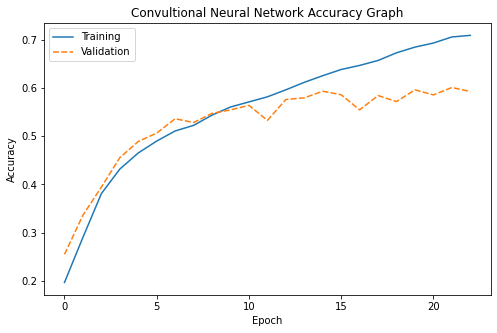

In [ ]:
plot_model_performance(CNN3_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN3.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN3.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

180/180 [==============================] - 22s 125ms/step - loss: 1.1859 - accuracy: 0.5925


Training Accuracy:	81.62616491317749
Training Loss:		0.5403488278388977

Validation Accuracy:	59.24830436706543
Validation Loss:	1.1858866214752197

Train/Validation Diff:	 22.37786054611206


In [ ]:
CNN3.save('Deliverables/CNN3_best_model.h5')

# Test Model

In [10]:
# Loading the best fit model 
from keras.models import load_model
model = load_model("CNN3_best_model.h5")

In [11]:
# just to map o/p values 
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

 the image is of angry


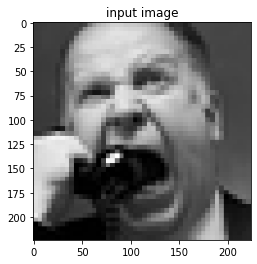

In [14]:
# path for the image to see if it predics correct class

path = "/content/drive/MyDrive/Data/test/angry/im118.png"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()